In [1]:
import pandas as pd
import numpy as np
import teetool as tt
import os

/home/will/anaconda3/envs/tt/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# identifying files
file_trajectories = "aircraft_trajectories"
file_runways = "airport_runways"

# shift parameters (to start at zero)
shift_x = -1800
shift_y = -1500
shift_z = -600

In [3]:
# read data trajectories
df = pd.read_csv("data/{0}.csv".format(file_trajectories))

# rename columns
df.rename(columns={'EASTINGS_M': 'x [m]',
                   'NORTHINGS_M': 'y [m]',
                   'ALTITUDE_M': 'z [m]'}, inplace=True)

In [4]:
# flick data into arrays

cluster_data_list = []

count_total = 0

for cluster_id in df.CLUSTER_ID.unique():
    # pass all clusters
    
    dfc = df[df["CLUSTER_ID"] == cluster_id]
    
    cluster_data = []

    for trajectory_id in dfc.TRAJECTORY_ID.unique():
        # pass all trajectories IN this cluster

        # extract values
        dft = dfc[dfc["TRAJECTORY_ID"] == trajectory_id]
        
        xn = dft["x [m]"].values/100.0 + shift_x; # metre to hectrometre (1 m = 0.001 hm)
        yn = dft["y [m]"].values/100.0 + shift_y; # metre to hectrometre
        zn = dft["z [m]"].values  + shift_z; # set altitude to zero
        
        Yn = np.array([xn, yn, zn]).T;
        
        (npoints, ndim) = Yn.shape
        
        # assume linearly distributed points (no indication otherwise)
        xn = np.linspace(0, 1, npoints)

        # add tuple to list
        cluster_data.append((xn, Yn))
    
    print("{0}   {1}".format(cluster_id, len(cluster_data)))
    
    count_total += len(cluster_data)
    
    cluster_data_list.append(cluster_data)

print("---------- + \n     {0}".format(count_total))

1   80
2   63
3   58
4   37
5   26
6   25
7   10
8   89
9   104
10   78
---------- + 
     570


In [5]:
# runway data
df_runw = pd.read_csv("data/{0}.csv".format(file_runways))

In [6]:
# store runway in a list of ([x],[y]) coordinates
runway_list = []

for i, runway in df_runw.iterrows():
    x1 = runway.Start_Easting/100.0  + shift_x; # *100 m _ hm
    y1 = runway.Start_Northing/100.0 + shift_y; # *100 m _ hm
    x2 = runway.End_Easting/100.0 + shift_x; # *100 m _ hm
    y2 = runway.End_Northing/100.0 + shift_y; # *100 m _ hm
    coords_x = np.array([x1, x2]).T
    coords_y = np.array([y1, y2]).T
    runway_list.append((coords_x, coords_y))

In [7]:
# build world
world = tt.World(name="DEN", ndim=3)

# only add first five clusters
for i, cluster_data in enumerate(cluster_data_list[:5]):
    world.addCluster(cluster_data, "c {0}".format(i))
    
# model
world.buildModel(settings={"model_type":"resampling", "ngaus":100})

In [11]:
# visualise trajectories
visual = tt.visual_3d.Visual_3d(world, size=(1400, 800))
# runways
for (x, y) in runway_list:
    visual.plot(x, y, [1, 1], color=(1,0,0), tube_radius=None)

# trajectories
visual.plotTrajectories(list_icluster=None, ntraj=50)

# 100 units
visual.plotGrid(resolution=100,
                outline=[0, 1100, 0, 1300, 0, 800]) # 100 units
visual.setLabels("Easting [hm]", "Northing [hm]", "Altitude [m]")
visual.setAxesFormat("%.0f")  # no ticks

# new view
visual.setView(azimuth=10, elevation=65, distance=3500)

visual.show()

In [12]:
# visualise flight corridors
visual = tt.visual_3d.Visual_3d(world, size=(1400, 800))
# runways
for (x, y) in runway_list:
    visual.plot(x, y, [1, 1], color=(1,0,0), tube_radius=None)

# flight corridors
visual.plotTube(list_icluster=None, alpha=1, resolution=[50, 50, 50])

# 100 units
visual.plotGrid(resolution=100,
                outline=[0, 1100, 0, 1300, 0, 800]) # 1000m = 1km = 1 km^3 is one grid block
visual.setLabels("Easting [hm]", "Northing [hm]", "Altitude [m]")
visual.setAxesFormat("%.0f")  # no ticks

# new view
visual.setView(azimuth=10, elevation=65, distance=3500)

visual.show() # note this stops the process and window needs to be closed to continue

/home/will/anaconda3/envs/tt/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


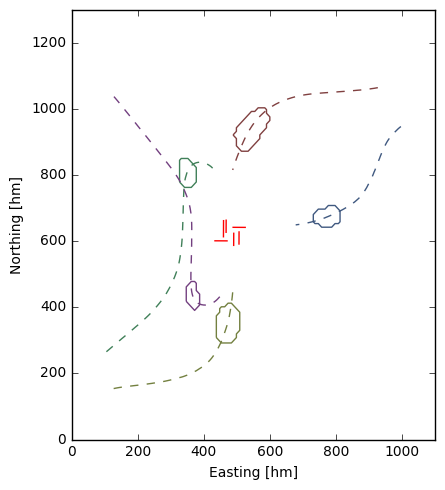

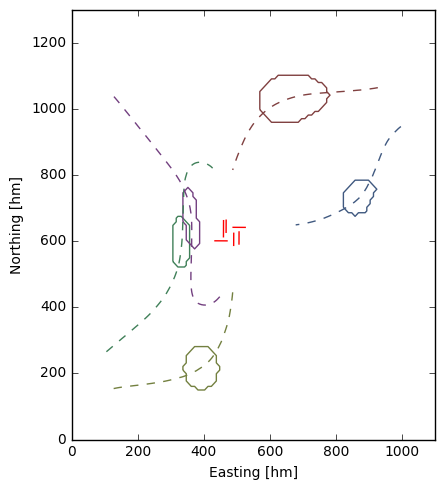

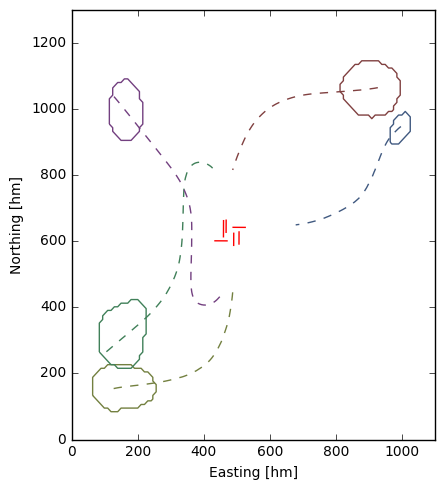

In [10]:
# visualise slices at different altitudes
for z in [300, 500, 700]:
    visual = tt.visual_2d.Visual_2d(world, figsize=(5, 5), dpi=600, tight_layout=True)
    visual.plotTube(z=z, resolution=[100, 100]) # 500 m
    visual.plotMean(linestyle='--')
    visual._ax.set_xlabel("Easting [hm]")
    visual._ax.set_ylabel("Northing [hm]")
    visual._ax.set_xlim([0, 1100])
    visual._ax.set_ylim([0, 1300])
    visual._ax.set_title("")
    visual._ax.set_aspect('equal', adjustable='box') # equal scale

    # plot runways
    for (x, y) in runway_list:
        visual.plot(x, y, color='r')

visual.show()